In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [2]:
import jax
import jax.numpy as jnp

In [3]:
# Load the MNIST results

results = np.load("results_diff_garch_models_M_8_N_1000_n_5_seed_0.npz")

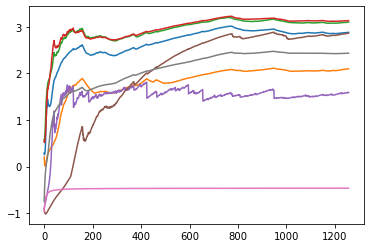

In [4]:
for k in range(8):

    plt.plot(
        np.cumsum(results["arr_0"][:, k])
        / (np.arange(1, results["arr_0"].shape[0] + 1))
    )

In [5]:
# %%
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, jit, value_and_grad
from functools import partial
import optax
import numpy as np
from jax.scipy.special import logsumexp
from scipy.stats import norm

import argparse

import cvxopt
from cvxopt import matrix, solvers

cvxopt.solvers.options["show_progress"] = False


compute_ons = 1
# N = np.load("results_garcht_M_10_N_1000_n_5_seed_0.npz")["arr_0"].shape[0]
N = np.load("results_diff_garch_models_M_8_N_1000_n_5_seed_0.npz")["arr_0"].shape[0]


# %% Auxiliary functions
def get_weights_expgrad(alpha, pll_t):
    def _step_weights(carry, i):
        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]

        # Exponentiated Gradients
        log_w = log_w + alpha * jnp.exp(li - jax.scipy.special.logsumexp(log_w + li))
        log_w = log_w - jax.scipy.special.logsumexp(log_w)

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate(
        [logw.reshape(1, -1), log_ws[:-1]], axis=0
    )  # we don't consider the last weight

    return log_ws


def get_weights_expgrad_bma(alpha, pll_t):
    def _step_weights(carry, i):
        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]

        # Exponentiated Gradients
        log_w = log_w + alpha * li
        log_w = log_w - jax.scipy.special.logsumexp(log_w)

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_weights_softbayes(alpha, pll_t):
    def _step_weights(carry, i):
        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]
        M_t = logsumexp(log_w + li)

        # Soft-Bayes
        log_w = log_w + logsumexp(
            jnp.array([jnp.log1p(-alpha), jnp.log(alpha) + (li - M_t)])
        )

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_weights_corrected_softbayes(M, pll_t):
    log_M = jnp.log(M)

    def _step_weights(carry, i):
        alpha_t = jnp.sqrt(log_M / (2 * M * (i)))
        alpha_tp1 = jnp.sqrt(log_M / (2 * M * (i + 1)))

        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]
        M_t = logsumexp(log_w + li)

        # Soft-Bayes
        A = log_w
        B = jnp.log(
            1 - alpha_t + alpha_t * jnp.exp(li - M_t)
        )  # logsumexp(jnp.array([jnp.log1p(-alpha_t) * jnp.ones(pll_t.shape[0]), jnp.log(alpha_t) + (li - M_t)]))
        C = jnp.log(alpha_tp1 / alpha_t) * jnp.ones(pll_t.shape[0])
        D = jnp.log(1 - alpha_tp1 / alpha_t) + jnp.ones(pll_t.shape[0]) * jnp.log(1 / M)
        # print(A.shape, B.shape, C.shape, D.shape)
        # print((A + B + C).shape)
        # print(D.shape)
        log_w = logsumexp(jnp.array([A + B + C, D]), axis=0)
        # print(carry.shape, log_w.shape)

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_static_weights(pll_t):  # best constant rebalanced portfolio (BCRP)

    def neg_log_wealth(log_weights, pll_t):  # log_weights are not normalized!
        log_mix = logsumexp(log_weights + pll_t.T - logsumexp(log_weights), axis=1)

        return -jnp.sum(log_mix)

    neg_log_wealth_jit = jit(neg_log_wealth)

    init_params = jnp.log(
        jnp.ones(pll_t.shape[0])
        + 0.3 * jax.random.normal(jax.random.PRNGKey(my_seed + 20), (pll_t.shape[0],))
    )

    # Define the optimizer
    optimizer = optax.adam(learning_rate=0.01)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit)
    def update(params, opt_state, pll_t):
        loss, grads = value_and_grad(neg_log_wealth_jit)(params, pll_t)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    num_steps = 1000
    loss_vals = []
    for step in range(num_steps):
        loss, params, opt_state = update(params, opt_state, pll_t)
        loss_vals.append(loss)

    static_weights = jnp.exp(params - logsumexp(params))

    return static_weights


# Modified from the Universal Portfolios library
# https://github.com/Marigold/universal-portfolios/blob/master/universal/algos/ons.py
# Available under MIT License
class ONS:
    def __init__(self, delta=1 / 8, beta=1e-5, eta=0.0):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super().__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta

    def init_weights(self, m):
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T

        return np.ones(m) / m

    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1.0 / self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """Projection of x to simplex indiced by matrix M. Uses quadratic programming."""
        m = M.shape[0]

        P = matrix(2 * M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m, 1)))
        A = matrix(np.ones((1, m)))
        b = matrix(1.0)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol["x"])


def get_weights_ons(delta, beta, eta, pll_t):
    reward_t = np.exp(pll_t)
    max_reward_t = reward_t.max(0, keepdims=True)
    reward_t_norm = reward_t / max_reward_t

    ons = ONS(delta, beta, eta)
    current_weights = ons.init_weights(pll_t.shape[0])
    all_weights = [current_weights]

    for current_reward in reward_t_norm.T:
        try:
            current_weights = ons.step(current_reward, current_weights)
            all_weights.append(current_weights)
        except:
            print(current_reward)
            print(current_weights)
            raise Exception("Error in ONS")

    all_weights = np.maximum(
        np.stack(all_weights), np.zeros_like(np.stack(all_weights)) + 1e-64
    )

    return all_weights


# %% Generating the data
# J =

for my_seed in range(10):
    # pll_t = np.load(f"results_garcht_M_10_N_1000_n_5_seed_{my_seed}.npz")["arr_0"].T
    pll_t = np.load(f"results_diff_garch_models_M_8_N_1000_n_5_seed_{my_seed}.npz")[
        "arr_0"
    ].T
    # Get shape of array
    J, N = pll_t.shape

    # Find NaN values
    nan_mask = np.isnan(pll_t)

    # For each row with NaNs, replace with mean of neighboring columns
    for i in range(J):
        nan_idx = np.where(nan_mask[i])[0]
        for idx in nan_idx:
            # Get window of 10 values on each side, excluding NaNs
            window_start = max(0, idx - 10)
            window_end = min(N, idx + 11)
            window = pll_t[i, window_start:window_end]
            window = window[~np.isnan(window)]

            # Replace NaN with mean of window
            if len(window) > 0:
                pll_t[i, idx] = np.mean(window)

    rewards = {}
    weights = {}

    # computing the weights
    logws_eg = get_weights_expgrad(1e-2, pll_t)
    weights["eg"] = logws_eg

    logws_bma = get_weights_expgrad_bma(1, pll_t)
    weights["bma"] = logws_bma

    static_weights = get_static_weights(pll_t)
    weights["static"] = static_weights

    logws_softbayes = get_weights_corrected_softbayes(J, pll_t)
    weights["softbayes"] = logws_softbayes

    # computing rewards
    reward_t_eg = np.cumsum(logsumexp(pll_t.T + logws_eg, axis=1)) / np.arange(1, N + 1)
    rewards["eg"] = reward_t_eg

    reward_t_bma = np.cumsum(logsumexp(pll_t.T + logws_bma, axis=1)) / np.arange(
        1, N + 1
    )
    rewards["bma"] = reward_t_bma

    reward_t_static = np.cumsum(
        logsumexp(pll_t.T + np.log(static_weights), axis=1)
    ) / np.arange(1, N + 1)
    rewards["static"] = reward_t_static

    reward_t_softbayes = np.cumsum(
        logsumexp(pll_t.T + logws_softbayes, axis=1)
    ) / np.arange(1, N + 1)
    rewards["softbayes"] = reward_t_softbayes

    if compute_ons:
        # normalizing the rewards (exponentiated log predictive values)
        ws_ons = get_weights_ons(0.8, 1e-2, 0.01, pll_t)
        weights["ons"] = ws_ons

        reward_t_ons = np.cumsum(
            logsumexp(pll_t.T + np.log(ws_ons[:-1]), axis=1)
        ) / np.arange(1, N + 1)
        rewards["ons"] = reward_t_ons

        np.savez(
            f"results_garch_seed_{my_seed}.npz",
            logws_eg,
            reward_t_eg,
            logws_bma,
            reward_t_bma,
            static_weights,
            reward_t_static,
            ws_ons,
            reward_t_ons,
            logws_softbayes,
            reward_t_softbayes,
        )
    else:
        np.savez(
            f"results_garch_seed_{my_seed}_no_ons.npz",
            logws_eg,
            reward_t_eg,
            logws_bma,
            reward_t_bma,
            static_weights,
            reward_t_static,
            logws_softbayes,
            reward_t_softbayes,
        )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
logws_egs = []
reward_t_eg_s = []
logws_bmas = []
reward_t_bmas = []
static_weights_s = []
reward_t_statics = []
logws_softbayes_s = []
reward_t_softbayes_s = []

ws_ons = []
reward_t_ons = []

for seed in range(10):
    results = np.load(f"results_garch_seed_{seed}.npz")
    logws_egs.append(results["arr_0"])
    reward_t_eg_s.append(results["arr_1"])
    logws_bmas.append(results["arr_2"])
    reward_t_bmas.append(results["arr_3"])
    static_weights_s.append(results["arr_4"])
    reward_t_statics.append(results["arr_5"])

    ws_ons.append(results["arr_6"])
    reward_t_ons.append(results["arr_7"])
    logws_softbayes_s.append(results["arr_8"])
    reward_t_softbayes_s.append(results["arr_9"])

log_ws_eg = np.stack(logws_egs)
reward_t_eg = np.stack(reward_t_eg_s)
logws_bma = np.stack(logws_bmas)
reward_t_bma = np.stack(reward_t_bmas)
static_weights = np.stack(static_weights_s)
reward_t_static = np.stack(reward_t_statics)
logws_softbayes = np.stack(logws_softbayes_s)
reward_t_softbayes = np.stack(reward_t_softbayes_s)

ws_ons = np.stack(ws_ons)
reward_t_ons = np.stack(reward_t_ons)

In [7]:
logws_softbayes.shape, log_ws_eg.shape

((10, 1257, 8), (10, 1257, 8))

In [8]:
colors = ["#FE7F2D", "#780116", "#FCCA46", "#A1C181", "#619B8A"]
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", weight="normal")
plt.rc("font", size=SIZE_DEFAULT)
plt.rc("axes", titlesize=SIZE_LARGE)
plt.rc("axes", labelsize=SIZE_LARGE)
plt.rc("xtick", labelsize=SIZE_DEFAULT)
plt.rc("ytick", labelsize=SIZE_DEFAULT)


def make_plot(
    x, y, labels, colors, ax, linestyle="solid", offsets=None, ylim=None, ticks_y=True
):
    if offsets is None:
        offsets = [
            0.0,
        ] * len(labels)

    # Plot each of the main lines
    for i, label in enumerate(labels):
        y_mean = np.mean(y[i], axis=0)
        y_std = np.std(y[i], axis=0)

        ax.plot(
            x,
            np.quantile(y[i], 0.5, axis=0),
            label=label,
            color=colors[i],
            linewidth=2,
            linestyle=linestyle,
        )

        # for q, alpha in zip([0.10, 0.25, 0.45], [0.5, 0.4, 0.3]):
        #     ax.fill_between(
        #         x,
        #         np.quantile(y[i], 0.5 - q, axis=0),
        #         np.quantile(y[i], 0.5 + q, axis=0),
        #         color=colors[i],
        #         linewidth=2,
        #         alpha=alpha,
        #     )

        ax.fill_between(
            x,
            np.quantile(y[i], 0.1, axis=0),
            np.quantile(y[i], 0.9, axis=0),
            color=colors[i],
            linewidth=2,
            alpha=0.3,
        )

        ax.text(
            x[-1] * 1.01,
            np.median(y[i], axis=0)[-1] + offsets[i],
            label,
            color=colors[i],
            fontweight="bold",
            horizontalalignment="left",
            verticalalignment="center",
        )

    # Hide the all but the bottom spines (axis lines)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Only show ticks on the left and bottom spines
    if ticks_y:
        ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    ax.spines["bottom"].set_bounds(min(x), max(x))
    if ylim:
        ax.set_ylim(ylim)

In [9]:
print(np.median(reward_t_eg, axis=0)[-1])
print(np.median(reward_t_bma, axis=0)[-1])
print(np.median(reward_t_static, axis=0)[-1])
print(np.median(reward_t_ons, axis=0)[-1])
print(np.median(reward_t_softbayes, axis=0)[-1])

3.2486613718747734
3.0402240973877075
3.2957602729640643
3.2999663732171705
3.295702865278706


In [10]:
# Get median values
values = {
    "reward_t_eg": np.median(reward_t_eg, axis=0)[-1],
    "reward_t_bma": np.median(reward_t_bma, axis=0)[-1],
    "reward_t_static": np.median(reward_t_static, axis=0)[-1],
    "reward_t_ons": np.median(reward_t_ons, axis=0)[-1],
    "reward_t_softbayes": np.median(reward_t_softbayes, axis=0)[-1],
}

# Sort by value and print variable names in order
sorted_vars = sorted(values.items(), key=lambda x: x[1])
for var_name, _ in sorted_vars:
    print(var_name)

reward_t_bma
reward_t_eg
reward_t_softbayes
reward_t_static
reward_t_ons


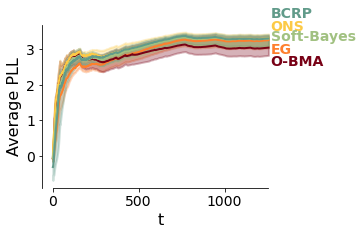

In [11]:
labels = [
    "EG",
    "O-BMA",
    "ONS",
    "Soft-Bayes",
    "BCRP",
]
fig, ax = plt.subplots(1, 1, figsize=(4.25, 3))
make_plot(
    np.arange(N),
    [
        reward_t_eg[:,],
        reward_t_bma[:,],
        reward_t_ons[:, :],
        reward_t_softbayes[:, :],
        reward_t_static[:,],
    ],
    labels,
    colors[:5],
    ax,
    offsets=[
        -0.25,
        -0.4,
        0.35,
        0.05,
        0.7,
    ],
)  # [-0.082, 0.059, 0.001, -0.049]
plt.xlabel("t")
plt.ylabel("Average PLL")

plt.savefig("BONG.pdf", bbox_inches="tight")

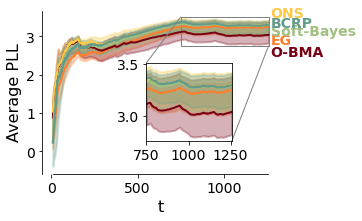

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Suppose these are your data arrays (replace with your actual data)
import numpy as np

N = 1257
labels = ["EG", "O-BMA", "ONS", "Soft-Bayes", "BCRP"]

# Main figure and axes
fig, ax = plt.subplots(figsize=(4.25, 3))

# Main plot
# reward_t_bma
# reward_t_eg
# reward_t_softbayes
# reward_t_static
# reward_t_ons

make_plot(
    np.arange(10, N),
    [
        reward_t_eg[:, 10:],
        reward_t_bma[:, 10:],
        reward_t_ons[:, 10:],
        reward_t_softbayes[:, 10:],
        reward_t_static[:, 10:],
    ],
    labels,
    colors,
    ax,
    offsets=[-0.18 * 2, -0.22 * 2, 0.15 * 2, -0.08 * 2, 0.03 * 2],
)

ax.set_xlabel("t")
ax.set_ylabel("Average PLL")

# Create the inset axes in the lower-right corner
# width="40%" and height="40%" is just an example sizing
ax_inset = inset_axes(
    ax,
    width="40%",
    height="40%",
    loc="lower right",
    bbox_to_anchor=(-0.1, 0.2, 0.9, 1.2),
    bbox_transform=ax.transAxes,  # interpret bbox in ax's coordinate system
    borderpad=0,
)


def make_inset_plot(x, y, colors, ax, linestyle="solid"):
    for i, label in enumerate(labels):
        y_mean = np.mean(y[i], axis=0)
        y_std = np.std(y[i], axis=0)

        ax.plot(
            x,
            np.quantile(y[i], 0.5, axis=0),
            color=colors[i],
            linewidth=2,
            linestyle=linestyle,
        )

        # for q, alpha in zip([0.10, 0.25, 0.45], [0.5, 0.4, 0.3]):
        #     ax.fill_between(
        #         x,
        #         np.quantile(y[i], 0.5 - q, axis=0),
        #         np.quantile(y[i], 0.5 + q, axis=0),
        #         color=colors[i],
        #         linewidth=2,
        #         alpha=alpha,
        #     )

        ax.fill_between(
            x,
            np.quantile(y[i], 0.1, axis=0),
            np.quantile(y[i], 0.9, axis=0),
            color=colors[i],
            linewidth=2,
            alpha=0.3,
        )


# Replot (or partially re-plot) only the region of interest in the inset
make_inset_plot(
    np.arange(750, N),
    [
        reward_t_eg[:, 750:],
        reward_t_bma[:, 750:],
        reward_t_ons[:, 750:],
        reward_t_softbayes[:, 750:],
        reward_t_static[:, 750:],
    ],
    colors,
    ax_inset,
)
# Zoom in on t > 1500
ax_inset.set_xlim(750, N)
# Adjust the y-limits to show the detail you want

# Optionally remove or customize tick labels on the inset
# ax_inset.set_xticks([1500, 1700, 1900])  # example

# If you'd like to draw connecting lines highlighting the zoomed region:
mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

plt.savefig("GARCH.pdf", bbox_inches="tight")
plt.show()

In [13]:
# M = np.load("results_garcht_M_10_N_1000_n_5_seed_0.npz")["arr_0"].shape[1]
M = J

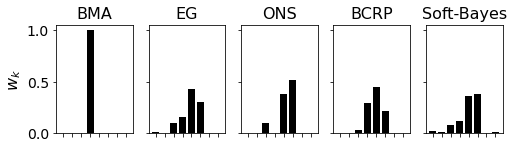

In [14]:
simu = 0
fig, axs = plt.subplots(1, 5, figsize=(8, 2), sharey=True)

axs[1].bar(range(M), np.exp(log_ws_eg)[simu, -1, :], color="black")
axs[1].set_xticks(range(M), [""] * M)
axs[1].set_title("EG")
axs[0].set_ylabel("$w_k$")

axs[0].bar(range(M), np.exp(logws_bma)[simu, -1, :], color="black")
axs[0].set_xticks(range(M), [""] * M)
axs[0].set_title("BMA")

axs[2].bar(range(M), ws_ons[simu, -1, :], color="black")
axs[2].set_xticks(range(M), [""] * M)
axs[2].set_title("ONS")

axs[3].bar(range(M), static_weights[simu, :], color="black")
axs[3].set_xticks(range(M), [""] * M)
axs[3].set_title("BCRP")

axs[4].bar(range(M), np.exp(logws_softbayes[simu, -1, :]), color="black")
axs[4].set_xticks(range(M), [""] * M)
axs[4].set_title("Soft-Bayes")

plt.savefig("weights_GARCH_final.pdf", bbox_inches="tight")

In [15]:
colors_hist = [
    "#008000",
    "#808080",
    "#0000FF",
    "#FFFF00",
    "#FF00FF",
    "#00FFFF",
    "#000000",
    "#FFA500",
]  # , '#FFA500', '#800080']#, '#FF0000', '#00FF00',  '#FFC0CB', '#800000', '#000080']

In [16]:
M

8

In [17]:
np.sum(static_weights[-1])

0.9999999999999998

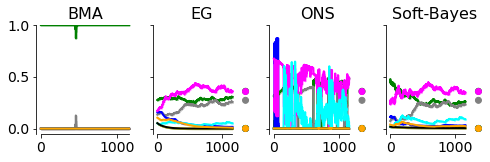

In [18]:
simu = 0
fig, axs = plt.subplots(1, 4, figsize=(8, 2), sharey=True)

make_plot(
    np.arange(N - 100),
    [np.exp(log_ws_eg)[-1:, 100:, i] for i in range(M)],
    [""] * M,
    colors_hist,
    axs[1],
    offsets=[0] * M,
    ylim=None, 
    ticks_y=None,
    
)
axs[1].set_title("EG")
axs[1].scatter([N + 100] * M, static_weights[-1], color=colors_hist)

make_plot(
    np.arange(N - 100),
    [np.exp(logws_bma)[-1:, 100:, i] for i in range(M)],
    [""] * M,
    colors_hist,
    axs[0],
    offsets=[0] * M,
    ylim=[-0.05, 1],
)
axs[0].set_title("BMA")

make_plot(
    np.arange(N - 100),
    [ws_ons[-1:, 100:-1, i] for i in range(M)],
    [""] * M,
    colors_hist,
    axs[2],
    offsets=[0] * M,
    ylim=None,
    ticks_y=None,
)
axs[2].scatter([N + 100] * M, static_weights[-1], color=colors_hist)
axs[2].set_title("ONS")

make_plot(
    np.arange(N - 100),
    [np.exp(logws_softbayes)[-1:, 100:, i] for i in range(M)],
    [""] * M,
    colors_hist,
    axs[3],
    offsets=[0] * M,
    ylim=None,
    ticks_y=None,
)
axs[3].scatter([N + 100] * M, static_weights[-1], color=colors_hist)
axs[3].set_title("Soft-Bayes")

plt.savefig("weights_GARCH_evolutions.pdf", bbox_inches="tight")

In [19]:
N


1257

# Learning Rate Ablation

In [20]:
# %%
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import lax, jit, value_and_grad
from functools import partial
import optax
import numpy as np
from jax.scipy.special import logsumexp
from scipy.stats import norm

import argparse

import cvxopt
from cvxopt import matrix, solvers

cvxopt.solvers.options["show_progress"] = False


compute_ons = 1
# N = np.load("results_garcht_M_10_N_1000_n_5_seed_0.npz")["arr_0"].shape[0]
N = np.load("results_diff_garch_models_M_8_N_1000_n_5_seed_0.npz")["arr_0"].shape[0]


# %% Auxiliary functions
def get_weights_expgrad(alpha, pll_t):
    def _step_weights(carry, i):
        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]

        # Exponentiated Gradients
        log_w = log_w + alpha * jnp.exp(li - jax.scipy.special.logsumexp(log_w + li))
        log_w = log_w - jax.scipy.special.logsumexp(log_w)

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate(
        [logw.reshape(1, -1), log_ws[:-1]], axis=0
    )  # we don't consider the last weight

    return log_ws


def get_weights_expgrad_bma(alpha, pll_t):
    def _step_weights(carry, i):
        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]

        # Exponentiated Gradients
        log_w = log_w + alpha * li
        log_w = log_w - jax.scipy.special.logsumexp(log_w)

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_weights_softbayes(alpha, pll_t):
    def _step_weights(carry, i):
        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]
        M_t = logsumexp(log_w + li)

        # Soft-Bayes
        log_w = log_w + logsumexp(
            jnp.array([jnp.log1p(-alpha), jnp.log(alpha) + (li - M_t)])
        )

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_weights_corrected_softbayes(M, pll_t):
    log_M = jnp.log(M)

    def _step_weights(carry, i):
        alpha_t = jnp.sqrt(log_M / (2 * M * (i)))
        alpha_tp1 = jnp.sqrt(log_M / (2 * M * (i + 1)))

        log_w = carry

        li = jnp.asarray(pll_t)[:, i - 1]
        M_t = logsumexp(log_w + li)

        # Soft-Bayes
        A = log_w
        B = jnp.log(
            1 - alpha_t + alpha_t * jnp.exp(li - M_t)
        )  # logsumexp(jnp.array([jnp.log1p(-alpha_t) * jnp.ones(pll_t.shape[0]), jnp.log(alpha_t) + (li - M_t)]))
        C = jnp.log(alpha_tp1 / alpha_t) * jnp.ones(pll_t.shape[0])
        D = jnp.log(1 - alpha_tp1 / alpha_t) + jnp.ones(pll_t.shape[0]) * jnp.log(1 / M)
        # print(A.shape, B.shape, C.shape, D.shape)
        # print((A + B + C).shape)
        # print(D.shape)
        log_w = logsumexp(jnp.array([A + B + C, D]), axis=0)
        # print(carry.shape, log_w.shape)

        return log_w, log_w

    logw = jnp.log(jnp.ones(pll_t.shape[0]) / pll_t.shape[0])
    w = jnp.exp(logw)
    final_log_w, log_ws = lax.scan(
        _step_weights, logw, jnp.arange(1, pll_t.shape[1] + 1)
    )

    # optimized log-weights
    log_ws = jnp.concatenate([logw.reshape(1, -1), log_ws[:-1]], axis=0)

    return log_ws


def get_static_weights(pll_t):  # best constant rebalanced portfolio (BCRP)

    def neg_log_wealth(log_weights, pll_t):  # log_weights are not normalized!
        log_mix = logsumexp(log_weights + pll_t.T - logsumexp(log_weights), axis=1)

        return -jnp.sum(log_mix)

    neg_log_wealth_jit = jit(neg_log_wealth)

    init_params = jnp.log(
        jnp.ones(pll_t.shape[0])
        + 0.3 * jax.random.normal(jax.random.PRNGKey(my_seed + 20), (pll_t.shape[0],))
    )

    # Define the optimizer
    optimizer = optax.adam(learning_rate=0.01)
    opt_state = optimizer.init(init_params)

    # Define the update step
    @partial(jax.jit)
    def update(params, opt_state, pll_t):
        loss, grads = value_and_grad(neg_log_wealth_jit)(params, pll_t)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # Training loop
    params = init_params
    num_steps = 1000
    loss_vals = []
    for step in range(num_steps):
        loss, params, opt_state = update(params, opt_state, pll_t)
        loss_vals.append(loss)

    static_weights = jnp.exp(params - logsumexp(params))

    return static_weights


# Modified from the Universal Portfolios library
# https://github.com/Marigold/universal-portfolios/blob/master/universal/algos/ons.py
# Available under MIT License
class ONS:
    def __init__(self, delta=1 / 8, beta=1e-5, eta=0.0):
        """
        :param delta, beta, eta: Model parameters. See paper.
        """
        super().__init__()
        self.delta = delta
        self.beta = beta
        self.eta = eta

    def init_weights(self, m):
        self.A = np.mat(np.eye(m))
        self.b = np.mat(np.zeros(m)).T

        return np.ones(m) / m

    def step(self, r, p):
        # calculate gradient
        grad = np.mat(r / np.dot(p, r)).T
        # update A
        self.A += grad * grad.T
        # update b
        self.b += (1 + 1.0 / self.beta) * grad

        # projection of p induced by norm A
        pp = self.projection_in_norm(self.delta * self.A.I * self.b, self.A)
        return pp * (1 - self.eta) + np.ones(len(r)) / float(len(r)) * self.eta

    def projection_in_norm(self, x, M):
        """Projection of x to simplex indiced by matrix M. Uses quadratic programming."""
        m = M.shape[0]

        P = matrix(2 * M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m, 1)))
        A = matrix(np.ones((1, m)))
        b = matrix(1.0)

        sol = solvers.qp(P, q, G, h, A, b)
        return np.squeeze(sol["x"])


def get_weights_ons(delta, beta, eta, pll_t):
    reward_t = np.exp(pll_t)
    max_reward_t = reward_t.max(0, keepdims=True)
    reward_t_norm = reward_t / max_reward_t

    ons = ONS(delta, beta, eta)
    current_weights = ons.init_weights(pll_t.shape[0])
    all_weights = [current_weights]

    for current_reward in reward_t_norm.T:
        try:
            current_weights = ons.step(current_reward, current_weights)
            all_weights.append(current_weights)
        except:
            print(current_reward)
            print(current_weights)
            raise Exception("Error in ONS")

    all_weights = np.maximum(
        np.stack(all_weights), np.zeros_like(np.stack(all_weights)) + 1e-64
    )

    return all_weights


# %% Generating the data
# J =

for my_seed in range(10):
    # pll_t = np.load(f"results_garcht_M_10_N_1000_n_5_seed_{my_seed}.npz")["arr_0"].T
    pll_t = np.load(f"results_diff_garch_models_M_8_N_1000_n_5_seed_{my_seed}.npz")[
        "arr_0"
    ].T
    # Get shape of array
    J, N = pll_t.shape

    # Find NaN values
    nan_mask = np.isnan(pll_t)

    # For each row with NaNs, replace with mean of neighboring columns
    for i in range(J):
        nan_idx = np.where(nan_mask[i])[0]
        for idx in nan_idx:
            # Get window of 10 values on each side, excluding NaNs
            window_start = max(0, idx - 10)
            window_end = min(N, idx + 11)
            window = pll_t[i, window_start:window_end]
            window = window[~np.isnan(window)]

            # Replace NaN with mean of window
            if len(window) > 0:
                pll_t[i, idx] = np.mean(window)

    rewards = {}
    weights = {}

        # computing the weights
    logws_egm0 = get_weights_expgrad(1e-0, pll_t)
    weights["egm0"] = logws_egm0

    logws_egm2 = get_weights_expgrad(1e-2, pll_t)
    weights["egm2"] = logws_egm2

    # computing the weights
    logws_egm3 = get_weights_expgrad(1e-3, pll_t)
    weights["egm3"] = logws_egm3

    # computing the weights
    logws_egm4 = get_weights_expgrad(1e-4, pll_t)
    weights["egm4"] = logws_egm4

    # computing the weights
    logws_egm1 = get_weights_expgrad(1e-1, pll_t)
    weights["egm1"] = logws_egm1

    logws_bma = get_weights_expgrad_bma(1, pll_t)
    weights["bma"] = logws_bma

    static_weights = get_static_weights(pll_t)
    weights["static"] = static_weights

    logws_softbayes = get_weights_corrected_softbayes(J, pll_t)
    weights["softbayes"] = logws_softbayes

    # computing rewards
    reward_t_egm1 = np.cumsum(logsumexp(pll_t.T + logws_egm1, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm1"] = reward_t_egm1

    reward_t_egm2 = np.cumsum(logsumexp(pll_t.T + logws_egm2, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm2"] = reward_t_egm2

    reward_t_egm3 = np.cumsum(logsumexp(pll_t.T + logws_egm3, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm3"] = reward_t_egm3

    reward_t_egm4 = np.cumsum(logsumexp(pll_t.T + logws_egm4, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm4"] = reward_t_egm4

    reward_t_egm0 = np.cumsum(logsumexp(pll_t.T + logws_egm0, axis=1))/ \
        np.arange(1,N+1)
    rewards["egm5"] = reward_t_egm0

    reward_t_bma =  np.cumsum(logsumexp(pll_t.T + logws_bma, axis=1))/ \
        np.arange(1,N+1)
    rewards["bma"] = reward_t_bma

    reward_t_static = np.cumsum(logsumexp(pll_t.T + np.log(static_weights), axis=1))/  \
        np.arange(1, N+1)
    rewards["static"] = reward_t_static

    reward_t_softbayes = np.cumsum(logsumexp(pll_t.T + logws_softbayes, axis=1))/ \
        np.arange(1, N+1)
    rewards["softbayes"] = reward_t_softbayes

    # normalizing the rewards (exponentiated log predictive values)
    ws_ons_m4 = get_weights_ons(0.8,1e-4,0.01, pll_t)
    weights["ons_m4"] = ws_ons_m4
    ws_ons_m3 = get_weights_ons(0.8,1e-3,0.01, pll_t)
    weights["ons_m3"] = ws_ons_m3
    ws_ons_m2 = get_weights_ons(0.8,1e-2,0.01, pll_t)
    weights["ons_m2"] = ws_ons_m2
    ws_ons_m1 = get_weights_ons(0.8,1e-1,0.01, pll_t)
    weights["ons_m1"] = ws_ons_m1
    ws_ons_m0 = get_weights_ons(0.8,1,0.01, pll_t)
    weights["ons_m0"] = ws_ons_m0

    reward_t_ons_m4 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m4[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m4"] = reward_t_ons_m4
    reward_t_ons_m3 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m3[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m3"] = reward_t_ons_m3
    reward_t_ons_m2 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m2[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m2"] = reward_t_ons_m2
    reward_t_ons_m1 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m1[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m1"] = reward_t_ons_m1
    reward_t_ons_m0 =  np.cumsum(logsumexp(pll_t.T + np.log(ws_ons_m0[:-1]), axis=1))/ \
        np.arange(1,N+1)
    rewards["ons_m0"] = reward_t_ons_m0

    np.savez(f'results_setting_garch_seed_{my_seed}_lr_ablation.npz', logws_egm0, reward_t_egm0, logws_egm1, reward_t_egm1, logws_egm2, reward_t_egm2, logws_egm3, reward_t_egm3, logws_egm4, reward_t_egm4, logws_bma, reward_t_bma, static_weights, reward_t_static, logws_softbayes, reward_t_softbayes, ws_ons_m4, reward_t_ons_m4, ws_ons_m3, reward_t_ons_m3, ws_ons_m2, reward_t_ons_m2, ws_ons_m1, reward_t_ons_m1, ws_ons_m0, reward_t_ons_m0)

In [21]:
logws_egm0_s = []
reward_t_egm0_s = []
logws_egm1_s = []
reward_t_egm1_s = []
logws_egm2_s = []
reward_t_egm2_s = []
logws_egm3_s = []
reward_t_egm3_s = []
logws_egm4_s = []
reward_t_egm4_s = []
logws_bma_s = []
reward_t_bma_s = []
static_weights_s = []
reward_t_statics = []
logws_softbayes_s = []
reward_t_softbayes_s = []
logws_ons_m4_s = []
reward_t_ons_m4_s = []
logws_ons_m3_s = []
reward_t_ons_m3_s = []
logws_ons_m2_s = []
reward_t_ons_m2_s = []
logws_ons_m1_s = []
reward_t_ons_m1_s = []
logws_ons_m0_s = []
reward_t_ons_m0_s = []



for seed in range(10):
    results = np.load(f'results_setting_garch_seed_{seed}_lr_ablation.npz')
    logws_egm0_s.append(results['arr_0'])   
    reward_t_egm0_s.append(results['arr_1'])
    logws_egm1_s.append(results['arr_2'])
    reward_t_egm1_s.append(results['arr_3'])
    logws_egm2_s.append(results['arr_4'])
    reward_t_egm2_s.append(results['arr_5'])
    logws_egm3_s.append(results['arr_6']) 
    reward_t_egm3_s.append(results['arr_7'])
    logws_egm4_s.append(results['arr_8'])
    reward_t_egm4_s.append(results['arr_9'])
    logws_bma_s.append(results['arr_10'])
    reward_t_bma_s.append(results['arr_11'])
    static_weights_s.append(results['arr_12'])
    reward_t_statics.append(results['arr_13'])
    logws_softbayes_s.append(results['arr_14'])
    reward_t_softbayes_s.append(results['arr_15'])
    logws_ons_m4_s.append(results['arr_16'])
    reward_t_ons_m4_s.append(results['arr_17'])
    logws_ons_m3_s.append(results['arr_18'])
    reward_t_ons_m3_s.append(results['arr_19'])
    logws_ons_m2_s.append(results['arr_20'])
    reward_t_ons_m2_s.append(results['arr_21'])
    logws_ons_m1_s.append(results['arr_22'])
    reward_t_ons_m1_s.append(results['arr_23'])
    logws_ons_m0_s.append(results['arr_24'])
    reward_t_ons_m0_s.append(results['arr_25'])

log_ws_egm0 = np.stack(logws_egm0_s)
reward_t_egm0 = np.stack(reward_t_egm0_s)
log_ws_egm1 = np.stack(logws_egm1_s)
reward_t_egm1 = np.stack(reward_t_egm1_s)
log_ws_egm2 = np.stack(logws_egm2_s)
reward_t_egm2 = np.stack(reward_t_egm2_s)
log_ws_egm3 = np.stack(logws_egm3_s)
reward_t_egm3 = np.stack(reward_t_egm3_s)
log_ws_egm4 = np.stack(logws_egm4_s)
reward_t_egm4 = np.stack(reward_t_egm4_s)
logws_bma = np.stack(logws_bma_s)
reward_t_bma = np.stack(reward_t_bma_s)
static_weights = np.stack(static_weights_s)
reward_t_static = np.stack(reward_t_statics)
logws_softbayes = np.stack(logws_softbayes_s)
reward_t_softbayes = np.stack(reward_t_softbayes_s)
logws_ons_m4 = np.stack(logws_ons_m4_s)
reward_t_ons_m4 = np.stack(reward_t_ons_m4_s)
logws_ons_m3 = np.stack(logws_ons_m3_s)
reward_t_ons_m3 = np.stack(reward_t_ons_m3_s)
logws_ons_m2 = np.stack(logws_ons_m2_s)
reward_t_ons_m2 = np.stack(reward_t_ons_m2_s)
logws_ons_m1 = np.stack(logws_ons_m1_s)
reward_t_ons_m1 = np.stack(reward_t_ons_m1_s)
logws_ons_m0 = np.stack(logws_ons_m0_s)
reward_t_ons_m0 = np.stack(reward_t_ons_m0_s)


In [22]:
labels = ["EG (1e0)", "EG (1e-1)", 'EG (1e-2)', 'EG (1e-3)', 'EG (1e-4)', 'O-BMA', 'Soft-Bayes','BCRP', "ON (1e-4)", "ON (1e-3)", "ON (1e-2)", "ON (1e-1)", "ON (1e0)"]
rewards = [reward_t_egm0[:,10:], reward_t_egm1[:,10:], reward_t_egm2[:, 10:],  reward_t_egm3[:,10:], reward_t_egm4[:,10:],reward_t_bma[:,10:], reward_t_softbayes[:,10:],reward_t_static[:,10:],reward_t_ons_m4[:,10:], reward_t_ons_m3[:,10:], reward_t_ons_m2[:,10:], reward_t_ons_m1[:,10:], reward_t_ons_m0[:, 10:]]


In [23]:
for i, label_and_result in enumerate(zip(labels, rewards)):
    label, rewards = label_and_result
    print(f"{label} {np.median(rewards[:, -1]):.3f} {np.std(rewards[:, -1]):.2f}")

EG (1e0) 2.776 0.23
EG (1e-1) 3.188 0.13
EG (1e-2) 3.249 0.13
EG (1e-3) 2.978 0.14
EG (1e-4) 2.858 0.17
O-BMA 3.040 0.24
Soft-Bayes 3.296 0.13
BCRP 3.296 0.12
ON (1e-4) 3.159 0.12
ON (1e-3) 3.229 0.10
ON (1e-2) 3.300 0.13
ON (1e-1) 3.330 0.13
ON (1e0) 3.256 0.12
